In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')

In [2]:
path_to_vius = 'RawData/US_VIUS_2021'
path_to_moves = 'RawData/MOVES'
path_to_experian = 'PrivateData/registration/experian' # access for private data

selected_state = 'CA'
experian_file = 'cleanedExperian_7_Jun_24.csv'
experian_data = read_csv(os.path.join(path_to_experian,
                                     experian_file))
print(len(experian_data))
experian_data.head(5)

1210213


,state_abbr,county_name,fuel_ty,model_year,naics_lvl3,age,assign_wt_class,body_merged,vehicle_count
0,CA,ALAMEDA,Biodiesel,2011,,12,2,Pickup,1.0
1,CA,ALAMEDA,Biodiesel,2011,221,12,2,Pickup,1.0
2,CA,ALAMEDA,Biodiesel,2011,236,12,3,Chassis Cab,1.0
3,CA,ALAMEDA,Biodiesel,2011,236,12,3,Pickup,2.0
4,CA,ALAMEDA,Biodiesel,2011,237,12,2,Pickup,7.0


total trucks in CA registration data:
7945576.0
trucks by GWVR class in CA registration data:
                 vehicle_count
assign_wt_class               
2                    6736438.0
3                     373038.0
4                     136510.0
5                     106334.0
6                     129375.0
7                      87318.0
8                     376563.0


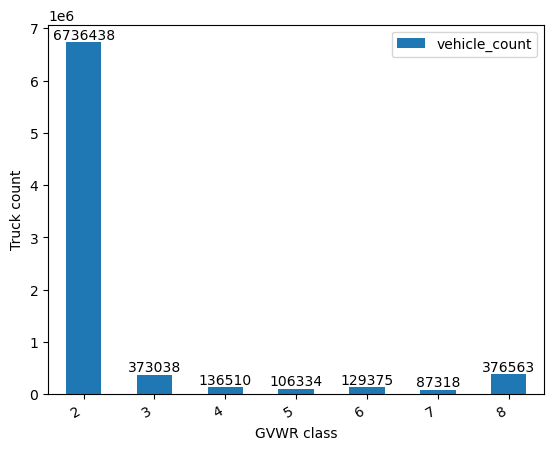

In [3]:
# select state-level results

body_type_to_drop = ['Passenger Van', 'Bus - Non-School',
       'Bus - School', 'Fire Truck', 'Motor Home', 'Military',
                    'Unknown']
experian_data = \
experian_data.loc[experian_data['state_abbr'] == selected_state]

experian_data = \
experian_data.loc[~experian_data['body_merged'].isin(body_type_to_drop)]

print('total trucks in {} registration data:'.format(selected_state))
print(experian_data.vehicle_count.sum())

experian_data_by_class = \
experian_data.groupby(['assign_wt_class'])[['vehicle_count']].sum()
print('trucks by GWVR class in {} registration data:'.format(selected_state))
print(experian_data_by_class)

experian_data_by_class.to_csv(os.path.join(path_to_experian, 'experian_count_' + selected_state + '.csv'))
ax = experian_data_by_class.plot(kind = 'bar')
rects = ax.patches

# Make some labels.
experian_data_by_class['vehicle_count'] = \
experian_data_by_class['vehicle_count'].astype(int)
labels = experian_data_by_class['vehicle_count'].tolist()

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )
plt.xlabel('GVWR class')
plt.ylabel('Truck count')
plt.xticks(rotation = 30, ha = 'right')
plt.show()

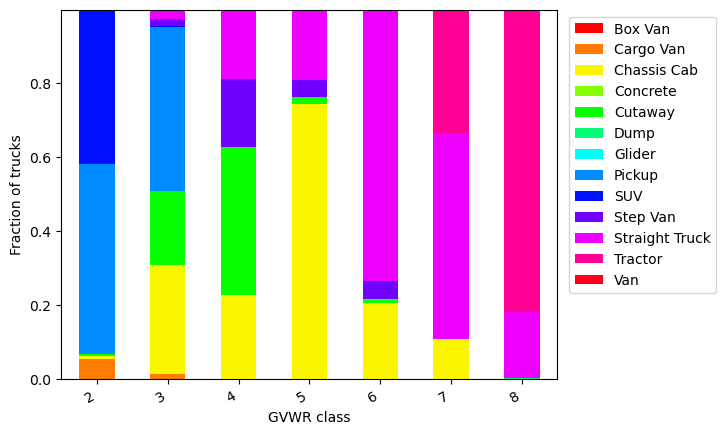

In [25]:
# look into gvwr class and body type crosstab
class_and_body_type = pd.pivot_table(experian_data,
                                     index = 'assign_wt_class',
                                     columns = 'body_merged',
                                     values = 'vehicle_count',
                                     aggfunc = 'sum')
# normalize
class_label = experian_data.body_merged.unique()
class_and_body_type.loc[:, class_label] = \
    class_and_body_type.loc[:, class_label].div(class_and_body_type.loc[:, class_label].sum(axis=1), axis=0)
# plot

class_and_body_type.plot(kind = 'bar', stacked = True, cmap= 'hsv')
plt.legend(bbox_to_anchor = (1.01,1.0))
plt.ylabel('Fraction of trucks')
plt.xlabel('GVWR class')
plt.xticks(rotation = 30, ha = 'right')
plt.show()



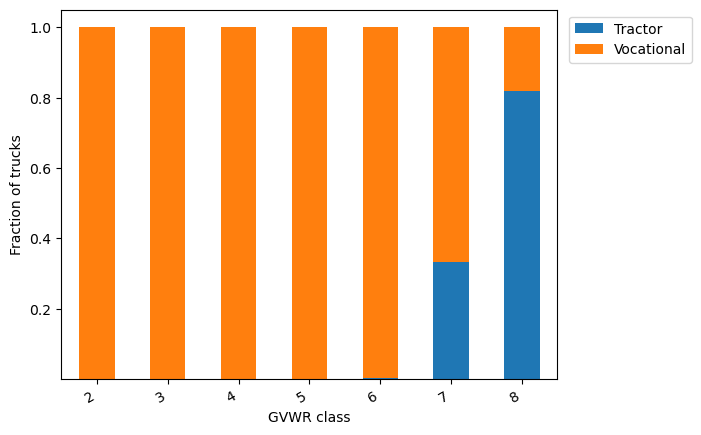

In [27]:
# body type assignment
class_label_mapping = {'Pickup': 'Vocational', 
                       'Chassis Cab': 'Vocational', 
                       'Cargo Van': 'Vocational', 
                       'Cutaway': 'Vocational', 
                       'Straight Truck': 'Vocational',
                       'Tractor': 'Tractor', 
                       'SUV': 'Vocational', 
                       'Step Van': 'Vocational', 
                       'Dump': 'Vocational', 
                       'Glider':'Tractor', 
                       'Van': 'Vocational',     
                       'Box Van':'Vocational', 
                       'Concrete': 'Vocational'}

experian_data.loc[:, 'body_type'] = \
experian_data.loc[:, 'body_merged'].map(class_label_mapping)

class_and_body_group = pd.pivot_table(experian_data,
                                     index = 'assign_wt_class',
                                     columns = 'body_type',
                                     values = 'vehicle_count',
                                     aggfunc = 'sum')
# normalize
class_label = experian_data.body_type.unique()
class_and_body_group.loc[:, class_label] = \
    class_and_body_group.loc[:, class_label].div(class_and_body_group.loc[:, class_label].sum(axis=1), axis=0)
# plot

class_and_body_group.plot(kind = 'bar', stacked = True)
plt.legend(bbox_to_anchor = (1.01,1.0))
plt.ylabel('Fraction of trucks')
plt.xlabel('GVWR class')
plt.xticks(rotation = 30, ha = 'right')
plt.show()

0
42
1981
2023


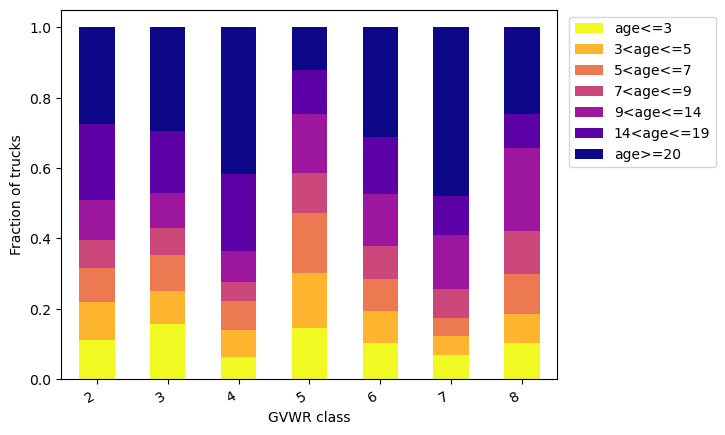

In [36]:
# AGE DISTRIBUTION
print(experian_data.age.min())
print(experian_data.age.max())

print(experian_data.model_year.min())
print(experian_data.model_year.max())

age_bin = [-1, 3, 5, 7, 9, 14, 19, 50]

age_bin_label = ['age<=3', '3<age<=5','5<age<=7', 
                 '7<age<=9', '9<age<=14', 
                 '14<age<=19', 'age>=20']

experian_data.loc[:, 'age_bin'] = pd.cut(experian_data.loc[:, 'age'], 
                                        bins = age_bin,
                                        labels = age_bin_label)

class_and_age_bin = pd.pivot_table(experian_data,
                                   index = 'assign_wt_class',
                                   columns = 'age_bin',
                                   values = 'vehicle_count',
                                   aggfunc = 'sum')
# normalize
# class_label = experian_data.body_merged.unique()
class_and_age_bin.loc[:, age_bin_label] = \
    class_and_age_bin.loc[:, age_bin_label].div(class_and_age_bin.loc[:, age_bin_label].sum(axis=1), axis=0)
# plot

class_and_age_bin.plot(kind = 'bar', 
                       stacked = True, 
                       cmap= 'plasma_r')

plt.legend(bbox_to_anchor = (1.01,1.0))
plt.ylabel('Fraction of trucks')
plt.xlabel('GVWR class')
plt.xticks(rotation = 30, ha = 'right')
plt.show()


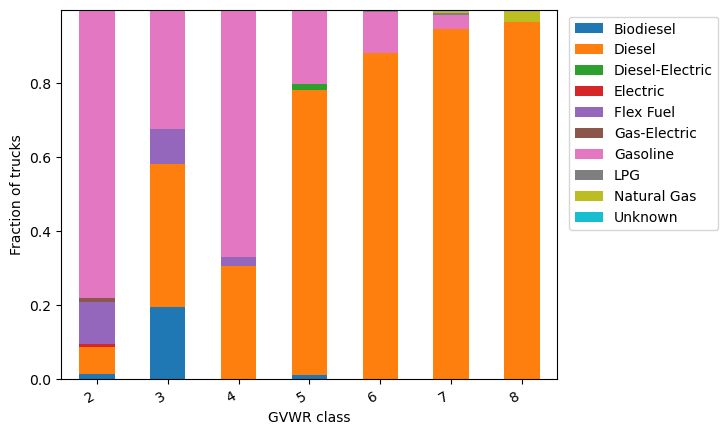

In [41]:
# FUEL TYPE DISTRIBUTION
experian_data.fuel_ty.unique()
fuel_type_mapping = {'Biodiesel':'Diesel', 
                     'Diesel-Electric': 'Hybrid', 
                     'Diesel':'Diesel', 
                     'Electric': 'Electric', 
                     'Flex Fuel': 'Other',
                     'Gas-Electric': 'Hybrid', 
                     'Gasoline': 'Gasoline', 
                     'LPG': 'Other', 
                     'Natural Gas': 'CNG', 
                     'Unknown': 'Other'}

# NO MAPPING

class_and_fuel = pd.pivot_table(experian_data,
                                index = 'assign_wt_class',
                                columns = 'fuel_ty',
                                values = 'vehicle_count',
                                aggfunc = 'sum')
# normalize
class_label = experian_data.fuel_ty.unique()
class_and_fuel.loc[:, class_label] = \
    class_and_fuel.loc[:, class_label].div(class_and_fuel.loc[:, class_label].sum(axis=1), axis=0)
# plot

class_and_fuel.plot(kind = 'bar', 
                       stacked = True, 
                       cmap= 'tab10')

plt.legend(bbox_to_anchor = (1.01,1.0))
plt.ylabel('Fraction of trucks')
plt.xlabel('GVWR class')
plt.xticks(rotation = 30, ha = 'right')
plt.show()



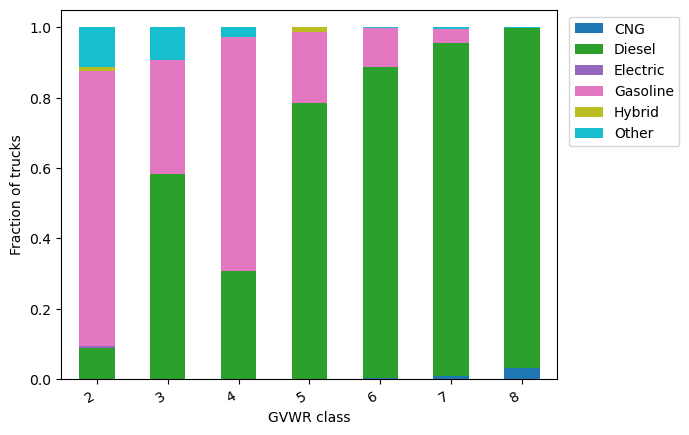

In [42]:
# with MAPPING
experian_data.loc[:, 'fuel_type_1'] =\
experian_data.loc[:, 'fuel_ty'].map(fuel_type_mapping)
class_and_fuel = pd.pivot_table(experian_data,
                                index = 'assign_wt_class',
                                columns = 'fuel_type_1',
                                values = 'vehicle_count',
                                aggfunc = 'sum')
# normalize
class_label = experian_data.fuel_type_1.unique()
class_and_fuel.loc[:, class_label] = \
    class_and_fuel.loc[:, class_label].div(class_and_fuel.loc[:, class_label].sum(axis=1), axis=0)
# plot

class_and_fuel.plot(kind = 'bar', 
                       stacked = True, 
                       cmap= 'tab10')

plt.legend(bbox_to_anchor = (1.01,1.0))
plt.ylabel('Fraction of trucks')
plt.xlabel('GVWR class')
plt.xticks(rotation = 30, ha = 'right')
plt.show()

In [7]:
experian_data.loc[:, 'naics_lvl3'].fillna(np.nan, inplace = True)
count_by_naics = \
experian_data.groupby('naics_lvl3')[['vehicle_count']].sum()
count_by_naics = count_by_naics.sort_values(by = 'vehicle_count', ascending = False)
count_by_naics.head(20)

,vehicle_count
naics_lvl3,
238,131262.0
484,88884.0
541,78754.0
,66765.0
236,54640.0
561,54438.0
532,51870.0
423,51149.0
921,35813.0


In [9]:
print(count_by_naics['vehicle_count'].sum())
print(experian_data.vehicle_count.sum())

1122594.0
7945576.0


In [15]:
experian_data.loc[experian_data['naics_lvl3'].isna(), 'vehicle_count'].sum()

6822982.0

In [12]:
experian_data['naics_lvl3'].unique()

array(['   ', '221', '236', '237', '238', '326', '332', '423', '424',
       '484', '519', '524', '532', '541', '561', '562', '811', '925', nan,
       '112', '445', '551', '721', '722', '921', '443', '451', '485',
       '113', '212', '333', '486', '492', '517', '523', '621', '713',
       '336', '441', '444', '533', '611', '111', '115', '312', '321',
       '327', '335', '922', '331', '453', '493', '511', '531', '813',
       '442', '624', '522', '814', '339', '488', '812', '311', '425',
       '322', '324', '337', '454', '211', '314', '712', '325', '711',
       '213', '323', '446', '623', '313', '315', '447', '482', '515',
       '518', '483', '512', '481', '334', '480', '448', '452', '622',
       '926', '924', '928', '491', '810', '316', '620', '923', '110',
       '114', '487', '525', '510', '927', '710', '920', '420', '440',
       '521', '520'], dtype=object)